In [1]:
# MobileNetV2

In [2]:
# Import Libraries

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Set Paths

train_path = "D:/PROJECT/PLANT DISEASE/fruit plant (train, test, validation)/fruit/train"
val_path   = "D:/PROJECT/PLANT DISEASE/fruit plant (train, test, validation)/fruit/validation"
test_path  = "D:/PROJECT/PLANT DISEASE/fruit plant (train, test, validation)/fruit/test"

In [4]:
# Data Augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load Data

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False  # For confusion matrix
)

Found 11496 images belonging to 12 classes.
Found 5784 images belonging to 12 classes.
Found 3504 images belonging to 12 classes.


In [6]:
# Build Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [9]:
# Train the Model

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15
)


Epoch 1/15
180/180 [==============================] - 311s 2s/step - loss: 0.4213 - accuracy: 0.8709 - val_loss: 0.2155 - val_accuracy: 0.9433
Epoch 2/15
180/180 [==============================] - 251s 1s/step - loss: 0.3349 - accuracy: 0.8920 - val_loss: 0.1753 - val_accuracy: 0.9509
Epoch 3/15
180/180 [==============================] - 229s 1s/step - loss: 0.2792 - accuracy: 0.9106 - val_loss: 0.1560 - val_accuracy: 0.9568
Epoch 4/15
180/180 [==============================] - 238s 1s/step - loss: 0.2460 - accuracy: 0.9219 - val_loss: 0.1382 - val_accuracy: 0.9621
Epoch 5/15
180/180 [==============================] - 252s 1s/step - loss: 0.2305 - accuracy: 0.9234 - val_loss: 0.1293 - val_accuracy: 0.9621
Epoch 6/15
180/180 [==============================] - 234s 1s/step - loss: 0.2059 - accuracy: 0.9377 - val_loss: 0.1246 - val_accuracy: 0.9628
Epoch 7/15
180/180 [==============================] - 237s 1s/step - loss: 0.1826 - accuracy: 0.9415 - val_loss: 0.1138 - val_accuracy: 0.9672

In [ ]:
# Save the Model

model.save("fruit_plant_disease_mobilenetv2_train_validation_test.h5")
print("Model saved!")

Model saved!


In [11]:
# Evaluate on Test Data

test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


55/55 [==============================] - 26s 470ms/step - loss: 0.0758 - accuracy: 0.9717
Test Accuracy: 0.9717
Test Loss: 0.0758


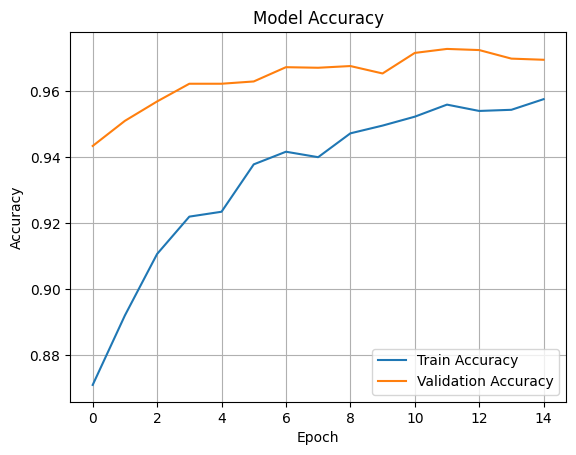

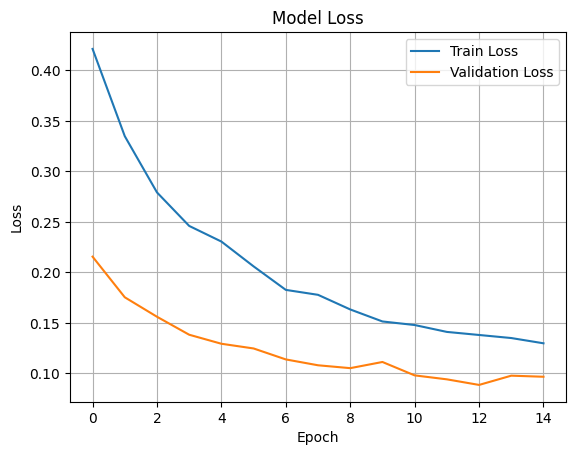

In [12]:
# Plot Accuracy & Loss

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


55/55 [==============================] - 26s 457ms/step


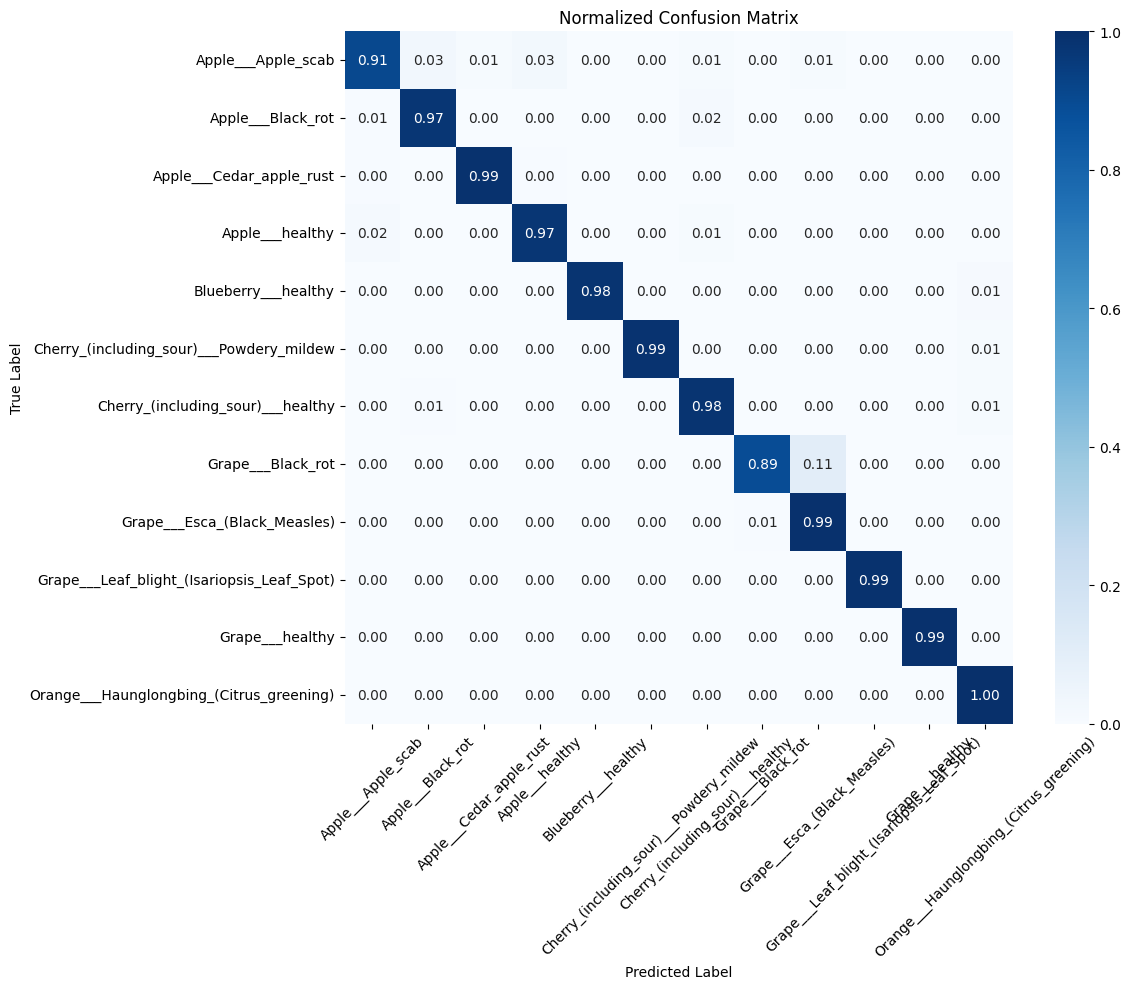

Classification Report:

                                            precision    recall  f1-score   support

                        Apple___Apple_scab       0.97      0.91      0.94       300
                         Apple___Black_rot       0.96      0.97      0.97       300
                  Apple___Cedar_apple_rust       0.99      0.99      0.99       204
                           Apple___healthy       0.96      0.97      0.97       300
                       Blueberry___healthy       1.00      0.98      0.99       300
  Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99       300
         Cherry_(including_sour)___healthy       0.96      0.98      0.97       300
                         Grape___Black_rot       0.99      0.89      0.94       300
              Grape___Esca_(Black_Measles)       0.89      0.99      0.94       300
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       1.00      0.99      0.99       300
                           Grape___healthy       1.

In [13]:
# Confusion Matrix + Classification Report

# Predict
test_data.reset()
y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = list(test_data.class_indices.keys())

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=labels))
